In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from dust_extinction.averages import CT06_MWGC, RL85_MWGC, RRP89_MWGC, F11_MWGC, I05_MWAvg, CT06_MWLoc, G21_MWAvg
import regions
from regions import Regions
from astropy.nddata import Cutout2D
from astropy.table import Table, Column, MaskedColumn
from astropy import table

In [2]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
import catalog_query as cq
from jwst_plots import make_cat_use, JWSTCatalog
import cutout_manager as cm

In [4]:
cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [5]:
basepath = '/orange/adamginsburg/jwst/cloudc/'

# Query Gaia Catalog

In [6]:
pos = SkyCoord('17:46:20.8194569665', '-28:37:52.4236707380', unit=(u.hourangle, u.deg), frame='icrs')
size_filabox = (2.6762805138*u.arcmin, 86.6778672344*u.arcsec)

gaia = cq.get_catalog('I/355/gaiadr3', pos, size_filabox[0], size_filabox[1])

In [7]:
gaia[:10]

RA_ICRS,DE_ICRS,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RUWE,FG,e_FG,Gmag,FBP,e_FBP,BPmag,FRP,e_FRP,RPmag,BP-RP,RV,e_RV,Vbroad,GRVSmag,QSO,Gal,NSS,XPcont,XPsamp,RVS,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And,Teff,logg,__Fe_H_,Dist,A0,HIP,PS1,SDSS13,SKYM2,TYC2,URAT1,AllWISE,APASS9,GSC23,RAVE5,_2MASS,RAVE6,RAJ2000,DEJ2000
deg,deg,,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,,,mag,,,mag,mag,km / s,km / s,km / s,mag,,,,,,,,,,,,K,log(cm.s**-2),,pc,mag,,,,,,,,,,,,,deg,deg
float64,float64,int64,float64,float64,float64,float32,float64,float64,float32,float64,float32,float64,float64,float32,float64,float32,float32,float64,float32,float32,float64,float64,float64,float32,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,float64,float64,float64,float64,float64,int32,int64,int64,int32,str12,str15,str19,int32,str10,str16,str17,str21,float64,float64
266.58223246813,-28.65143645525,4057519410567863552,0.6448,0.4704,--,--,--,--,--,--,--,--,12700.70166,89.48,15.427797,5395,11.53,16.008537,1.314e+04,19.02,14.451543,1.556994,--,--,--,--,0,0,0,1,0,0,0,0,0,0,0,--,--,--,--,--,--,73612665822258623,--,165250835,,,,--,S8DO063713,,17461973-2839052,,266.58223246813,-28.65143645525
266.58067620043,-28.65244643415,4057519410567863680,0.1310,0.0983,0.4739,0.1333,3.274,-0.757,0.185,-3.186,0.098,1.193,1835.79818,2.273,17.527805,246.1,8.415,19.360560,2622,15.06,16.201416,3.159143,--,--,--,--,0,0,0,1,0,0,0,0,0,1,0,--,--,--,--,--,--,73612665806747433,--,165250789,,,,--,S8DO063714,,17461936-2839084,,266.58068003495,-28.65243227589
266.57705084433,-28.65059540709,4057519410567864192,0.0367,0.0278,0.2998,0.0404,2.475,0.139,0.050,-2.471,0.029,0.997,8560.31542,4.562,15.856142,1647,7.372,17.296830,1.055e+04,12.27,14.690118,2.606711,--,--,--,--,0,0,0,1,0,0,0,0,0,1,0,7876.1,2.4971,-1.2032,7470.1270,5.6779,--,73612665770269587,--,--,,,,--,S8DO063718,,17461849-2839020,,266.57705013885,-28.65058442595
266.59304349974,-28.65192739455,4057519410568050816,0.2895,0.2079,0.6164,0.2725,4.049,-1.291,0.360,-3.837,0.192,0.981,420.07473,1.028,19.129051,82.79,9.988,20.543547,484.5,8.752,18.034610,2.508936,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,73612665930307977,--,165250941,,,,--,S8DO093362,,,,266.59305003763,-28.65191034007
266.57832597342,-28.64899325783,4057519410577539072,0.3118,0.2216,0.1404,0.3156,1.968,0.433,0.406,-1.920,0.213,1.074,399.17656,0.9696,19.184454,62.04,4.825,20.856780,524.2,6.786,17.949217,2.907562,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,73622665783241571,--,165250834,,,,--,,,17461877-2838561,,266.57832378263,-28.64898472356
266.58490385406,-28.64582618679,4057519410577548672,0.3607,0.2555,0.8681,0.3396,3.743,-2.208,0.510,-3.022,0.257,0.955,323.80759,1.022,19.411650,46.24,6.326,21.175879,453.9,7.745,18.105474,3.070404,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,73622665848825306,--,165250840,,,,--,,,17462037-2838448,,266.58491503575,-28.64581275486
266.58761426558,-28.64851468033,4057519414864777216,0.1214,0.0904,0.3898,0.1239,1.415,-0.196,0.166,-1.402,0.089,0.971,1282.36269,1.391,17.917340,273.9,9.445,19.244637,1535,14.1,16.782460,2.462177,--,--,--,--,0,0,0,0,0,0,0,0,1,1,0,4526.7,4.3462,-1.2576,771.1415,3.2575,--,73622665876122146,--,--,,,,--,,,,,266.58761525573,-28.64850845067
266.58359273696,-28.64987478071,4057519414864778368,0.3144,0.2283,2.1164,0.3201,12.042,-11.279,0.416,4.216,0.219,1.072,379.95113,1.06,19.238047,81.19,5.699,20.564817,465.6,6.154,18.077747,2.487070,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,73622665836100510,--,165250836,,,,--,S8DO093364,,,,266.58364986191,-28.64989351771


In [8]:
gaia_catalog = SkyCoord(gaia['RA_ICRS'], gaia['DE_ICRS'], unit=(u.deg, u.deg), frame='icrs')

In [9]:
# Query Gaia catalog for whole FOV
pos_ctr = SkyCoord('17:46:20.9311498783', '-28:35:16.3547733106', unit=(u.hourangle, u.deg), frame='icrs')
size_fov = (2.6521704908*u.arcmin, 8.5042423723*u.arcmin)

gaia_fov = cq.get_catalog('I/355/gaiadr3', pos_ctr, size_fov[1]*1.5, size_fov[0]*1.5)
#gaia_fov.write(f'{basepath}/catalogs/gaia_fov.fits', overwrite=True) # f'{basepath}/catalogs/gaia_filament.fits'
gaia_fov_catalog = SkyCoord(gaia_fov['RA_ICRS'], gaia_fov['DE_ICRS'], unit=(u.deg, u.deg), frame='icrs')

# Cutout Filament

In [10]:
cat_use = make_cat_use()
crds_use = cat_use.catalog['skycoord_ref']

In [11]:
im_filt_fn = f'{basepath}/images/jw02221-o002_t001_nircam_clear-f182m-merged-reproject-nodestreak_i2d-perfilt128.fits'
im_filt = fits.open(im_filt_fn)[0]

In [12]:
reg_fov = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/f4_fov_cloudc.reg')
gaia_cloudc_fov = gaia_fov[reg_fov[0].contains(gaia_fov_catalog, wcs=WCS(im_filt.header))]
gaia_cloudc_fov.write('/orange/adamginsburg/jwst/cloudc/catalogs/gaia_cloudc_fov.fits', overwrite=True)

In [13]:
reg_filabox = regions.RectangleSkyRegion(center=pos, width=size_filabox[1], height=size_filabox[0])
cutout_filt = Cutout2D(im_filt.data, position=pos, size=size_filabox, wcs=WCS(im_filt.header))

In [14]:
cutout_405 = cm.get_cutout_405(pos, size_filabox[0], size_filabox[1])
cutout_182 = cm.get_cutout_182(pos, size_filabox[0], size_filabox[1])

# Match Catalogs

In [17]:
max_offset = 0.1*u.arcsec
basecrds = SkyCoord(ra=cat_use.catalog['skycoord_ref'].ra, dec=cat_use.catalog['skycoord_ref'].dec)
crds = SkyCoord(ra=gaia_cloudc_fov['RA_ICRS'], dec=gaia_cloudc_fov['DE_ICRS'])

matches, sep, _ = crds.match_to_catalog_sky(basecrds, nthneighbor=1)
reverse_matches, reverse_sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)

mutual_matches = (reverse_matches[matches] == np.arange(len(matches)))
max_offset = 0.1*u.arcsec
newcrds = crds[(sep > max_offset) & (~mutual_matches)]
basecrds = SkyCoord([basecrds,newcrds])

print('Base coord length = ', len(basecrds))
print('Added new sources = ', len(newcrds)) 

Base coord length =  131302
Added new sources =  2


In [28]:
# Build the basetable, which should have ALL of the columns and combine the two tables
basetable = Table()
basetable['skycoord_ref'] = basecrds

max_offset = 0.1*u.arcsec

crds = SkyCoord(ra=gaia_cloudc_fov['RA_ICRS'], dec=gaia_cloudc_fov['DE_ICRS'])
matches, sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
reverse_matches, reverse_sep, _ = crds.match_to_catalog_sky(basecrds, nthneighbor=1)

mutual_matches = (reverse_matches[matches] == np.arange(len(matches)))

wl = 'gaia'

print(f'{wl} has ', len(gaia_cloudc_fov), ' sources. ', mutual_matches.sum(), ' matches found.')

basetable.add_column(name=f"sep_{wl}", col=sep)
basetable.add_column(name=f"id_{wl}", col=matches)
matchtb = gaia_cloudc_fov[matches]
matchtb['skycoord'] = SkyCoord(ra=matchtb['RA_ICRS'], dec=matchtb['DE_ICRS'])
badsep = sep > max_offset

#for cn in matchtb.colnames:
#    if isinstance(matchtb[cn], SkyCoord):
#        matchtb.rename_column(cn, f"{wl}_{cn}")
#        matchtb[f'mask_{wl}'] = badsep
#    else: 
#        matchtb[f'{cn}_{wl}'] = MaskedColumn(data=matchtb[cn], name=f'{cn}_{wl}')
#        matchtb[f'{cn}_{wl}'].mask[badsep] = True
#        # mask non-mutual matches
#        matchtb[f'{cn}_{wl}'].mask[~mutual_matches] = True
#        if hasattr(matchtb[cn], 'meta'):
#            matchtb[f'{cn}_{wl}'].meta = matchtb[cn].meta
#        matchtb.remove_column(cn)
matchtb[f'mask_{wl}'] = badsep

crds = SkyCoord(ra=cat_use.catalog['skycoord_ref'].ra, dec=cat_use.catalog['skycoord_ref'].dec)
matches, sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
reverse_matches, reverse_sep, _ = crds.match_to_catalog_sky(basecrds, nthneighbor=1)

mutual_matches = (reverse_matches[matches] == np.arange(len(matches)))

reverse_matchtb = cat_use.catalog[matches]
reverse_matchtb.rename_column('skycoord_ref', f'skycoord_jwst')

basetable = table.hstack([basetable, matchtb, reverse_matchtb], join_type='exact')

gaia has  565  sources.  564  matches found.


In [19]:
basetable.write(f'{basepath}/catalogs/matched_gaia.fits', overwrite=True)

In [29]:
matched_basetable = basetable[~basetable['mask_gaia']]

In [30]:
matched_basetable.write(f'{basepath}/catalogs/only_matched_gaia.fits', overwrite=True)

## Plot Matched Gaia

In [6]:
gaia = Table.read(f'{basepath}/catalogs/only_matched_gaia.fits')

In [7]:
gaia[:3]#.columns

skycoord_ref,sep_gaia,id_gaia,RA_ICRS,DE_ICRS,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RUWE,FG,e_FG,Gmag,FBP,e_FBP,BPmag,FRP,e_FRP,RPmag,BP-RP,RV,e_RV,Vbroad,GRVSmag,QSO,Gal,NSS,XPcont,XPsamp,RVS,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And,Teff,logg,__Fe_H_,Dist,A0,HIP,PS1,SDSS13,SKYM2,TYC2,URAT1,AllWISE,APASS9,GSC23,RAVE5,_2MASS,RAVE6,RAJ2000,DEJ2000,skycoord,mask_gaia,skycoord_jwst,skycoord_ref_filtername,sep_f410m,id_f410m,skycoord_f410m,flux_f410m,flux_err_f410m,mask_f410m,qfit_f410m,cfit_f410m,flux_init_f410m,flags_f410m,local_bkg_f410m,group_size_f410m,dra_f410m,ddec_f410m,std_ra_f410m,std_dec_f410m,nmatch_f410m,nmatch_good_f410m,flux_err_prop_f410m,flux_jy_f410m,mag_ab_f410m,eflux_jy_f410m,emag_ab_f410m,near_saturated_f410m_f410m,replaced_saturated_f410m,sep_f212n,id_f212n,skycoord_f212n,flux_f212n,flux_err_f212n,mask_f212n,qfit_f212n,cfit_f212n,flux_init_f212n,flags_f212n,local_bkg_f212n,group_size_f212n,dra_f212n,ddec_f212n,std_ra_f212n,std_dec_f212n,nmatch_f212n,nmatch_good_f212n,flux_err_prop_f212n,flux_jy_f212n,mag_ab_f212n,eflux_jy_f212n,emag_ab_f212n,near_saturated_f212n_f212n,replaced_saturated_f212n,sep_f466n,id_f466n,skycoord_f466n,flux_f466n,flux_err_f466n,mask_f466n,qfit_f466n,cfit_f466n,flux_init_f466n,flags_f466n,local_bkg_f466n,group_size_f466n,dra_f466n,ddec_f466n,std_ra_f466n,std_dec_f466n,nmatch_f466n,nmatch_good_f466n,flux_err_prop_f466n,flux_jy_f466n,mag_ab_f466n,eflux_jy_f466n,emag_ab_f466n,near_saturated_f466n_f466n,replaced_saturated_f466n,sep_f405n,id_f405n,skycoord_f405n,flux_f405n,flux_err_f405n,mask_f405n,qfit_f405n,cfit_f405n,flux_init_f405n,flags_f405n,local_bkg_f405n,group_size_f405n,dra_f405n,ddec_f405n,std_ra_f405n,std_dec_f405n,nmatch_f405n,nmatch_good_f405n,flux_err_prop_f405n,flux_jy_f405n,mag_ab_f405n,eflux_jy_f405n,emag_ab_f405n,near_saturated_f405n_f405n,replaced_saturated_f405n,sep_f187n,id_f187n,skycoord_f187n,flux_f187n,flux_err_f187n,mask_f187n,qfit_f187n,cfit_f187n,flux_init_f187n,flags_f187n,local_bkg_f187n,group_size_f187n,dra_f187n,ddec_f187n,std_ra_f187n,std_dec_f187n,nmatch_f187n,nmatch_good_f187n,flux_err_prop_f187n,flux_jy_f187n,mag_ab_f187n,eflux_jy_f187n,emag_ab_f187n,near_saturated_f187n_f187n,replaced_saturated_f187n,sep_f182m,id_f182m,skycoord_f182m,flux_f182m,flux_err_f182m,mask_f182m,qfit_f182m,cfit_f182m,flux_init_f182m,flags_f182m,local_bkg_f182m,group_size_f182m,dra_f182m,ddec_f182m,std_ra_f182m,std_dec_f182m,nmatch_f182m,nmatch_good_f182m,flux_err_prop_f182m,flux_jy_f182m,mag_ab_f182m,eflux_jy_f182m,emag_ab_f182m,near_saturated_f182m_f182m,replaced_saturated_f182m,flux_jy_410m405,mag_ab_410m405,flux_jy_405m410,mag_ab_405m410,flux_jy_182m187,mag_ab_182m187,flux_jy_187m182,mag_ab_187m182
"deg,deg",deg,,deg,deg,,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,,,mag,,,mag,mag,km / s,km / s,km / s,mag,,,,,,,,,,,,K,log(cm.s**-2),,pc,mag,,,,,,,,,,,,,deg,deg,"deg,deg",,"deg,deg",,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy
SkyCoord,float64,int64,float64,float64,int64,float64,float64,float64,float32,float64,float64,float32,float64,float32,float64,float64,float32,float64,float32,float32,float64,float32,float32,float64,float64,float64,float32,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,float64,float64,float64,float64,float64,int32,int64,int64,int32,bytes12,bytes15,bytes19,int32,bytes10,bytes16,bytes17,bytes21,float64,float64,SkyCoord,bool,SkyCoord,bytes5,float64,int64,SkyCoord,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,bool,bool,float64,int64,SkyCoord,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64

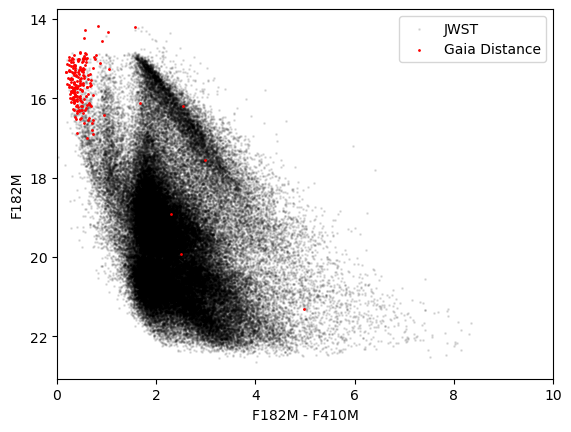

In [17]:
ax = plt.subplot(111)
cat_use.plot_CMD('F182M', 'F410M', 'F182M', color='k', alpha=0.1, s=1, label='JWST', ax=ax)
ax.scatter(gaia['mag_ab_f182m']-gaia['mag_ab_f410m'], gaia['mag_ab_f182m'], s=1, label='Gaia Distance', color='red')#, c=gaia['Dist'])
ax.set_xlabel('F182M - F410M')
ax.set_ylabel('F182M')
ax.set_xlim(0, 10)
ax.legend()
#plt.colorbar(im, label='Distance (pc)', ax=ax)

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


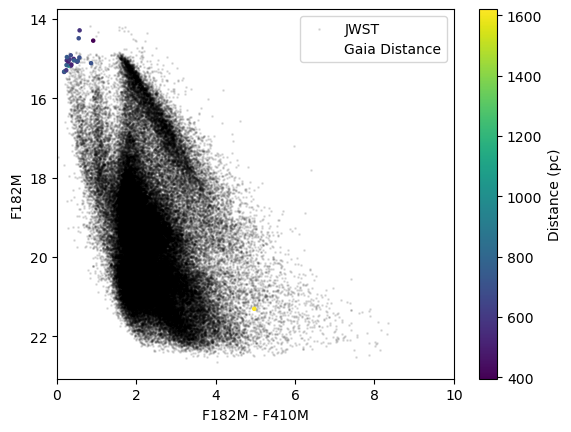

In [11]:
ax = plt.subplot(111)
cat_use.plot_CMD('F182M', 'F410M', 'F182M', color='k', alpha=0.1, s=1, label='JWST', ax=ax)
im = plt.scatter(gaia['mag_ab_f182m']-gaia['mag_ab_f410m'], gaia['mag_ab_f182m'], s=5, label='Gaia Distance', c=gaia['Dist'])
ax.set_xlabel('F182M - F410M')
ax.set_ylabel('F182M')
ax.set_xlim(0, 10)
ax.legend()
plt.colorbar(im, label='Distance (pc)', ax=ax)

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


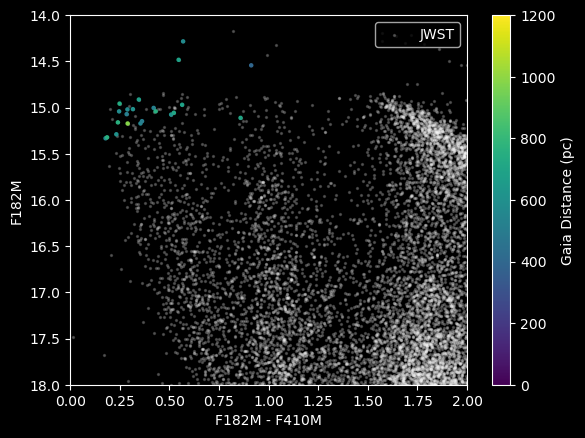

In [22]:
plt.style.use('dark_background')
ax = plt.subplot(111)
cat_use.plot_CMD('F182M', 'F410M', 'F182M', color='white', alpha=0.2, s=2, label='JWST', ax=ax)
im = plt.scatter(gaia['mag_ab_f182m']-gaia['mag_ab_f410m'], gaia['mag_ab_f182m'], s=5, c=gaia['Dist'], vmin=0, vmax=1200)
ax.set_xlabel('F182M - F410M')
ax.set_ylabel('F182M')
ax.set_xlim(0, 2)
ax.set_ylim(18, 14)
ax.legend(loc='upper right')
plt.colorbar(im, label='Gaia Distance (pc)', ax=ax)

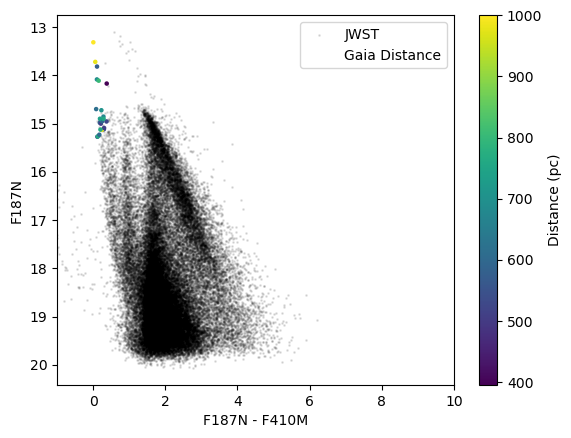

In [19]:
ax = plt.subplot(111)
cat_use.plot_CMD('F187N', 'F410M', 'F187N', color='k', alpha=0.1, s=1, label='JWST', ax=ax)
im = plt.scatter(gaia['mag_ab_f187n']-gaia['mag_ab_f410m'], gaia['mag_ab_f187n'], s=5, label='Gaia Distance', c=gaia['Dist'])
ax.set_xlabel('F187N - F410M')
ax.set_ylabel('F187N')
ax.set_xlim(-1, 10)
ax.legend()
plt.colorbar(im, label='Distance (pc)', ax=ax)

In [39]:
gaia[gaia['Dist']>5000]

skycoord_ref,sep_gaia,id_gaia,RA_ICRS,DE_ICRS,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RUWE,FG,e_FG,Gmag,FBP,e_FBP,BPmag,FRP,e_FRP,RPmag,BP-RP,RV,e_RV,Vbroad,GRVSmag,QSO,Gal,NSS,XPcont,XPsamp,RVS,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And,Teff,logg,__Fe_H_,Dist,A0,HIP,PS1,SDSS13,SKYM2,TYC2,URAT1,AllWISE,APASS9,GSC23,RAVE5,_2MASS,RAVE6,RAJ2000,DEJ2000,skycoord,mask_gaia,skycoord_jwst,skycoord_ref_filtername,sep_f410m,id_f410m,skycoord_f410m,flux_f410m,flux_err_f410m,mask_f410m,qfit_f410m,cfit_f410m,flux_init_f410m,flags_f410m,local_bkg_f410m,group_size_f410m,dra_f410m,ddec_f410m,std_ra_f410m,std_dec_f410m,nmatch_f410m,nmatch_good_f410m,flux_err_prop_f410m,flux_jy_f410m,mag_ab_f410m,eflux_jy_f410m,emag_ab_f410m,near_saturated_f410m_f410m,replaced_saturated_f410m,sep_f212n,id_f212n,skycoord_f212n,flux_f212n,flux_err_f212n,mask_f212n,qfit_f212n,cfit_f212n,flux_init_f212n,flags_f212n,local_bkg_f212n,group_size_f212n,dra_f212n,ddec_f212n,std_ra_f212n,std_dec_f212n,nmatch_f212n,nmatch_good_f212n,flux_err_prop_f212n,flux_jy_f212n,mag_ab_f212n,eflux_jy_f212n,emag_ab_f212n,near_saturated_f212n_f212n,replaced_saturated_f212n,sep_f466n,id_f466n,skycoord_f466n,flux_f466n,flux_err_f466n,mask_f466n,qfit_f466n,cfit_f466n,flux_init_f466n,flags_f466n,local_bkg_f466n,group_size_f466n,dra_f466n,ddec_f466n,std_ra_f466n,std_dec_f466n,nmatch_f466n,nmatch_good_f466n,flux_err_prop_f466n,flux_jy_f466n,mag_ab_f466n,eflux_jy_f466n,emag_ab_f466n,near_saturated_f466n_f466n,replaced_saturated_f466n,sep_f405n,id_f405n,skycoord_f405n,flux_f405n,flux_err_f405n,mask_f405n,qfit_f405n,cfit_f405n,flux_init_f405n,flags_f405n,local_bkg_f405n,group_size_f405n,dra_f405n,ddec_f405n,std_ra_f405n,std_dec_f405n,nmatch_f405n,nmatch_good_f405n,flux_err_prop_f405n,flux_jy_f405n,mag_ab_f405n,eflux_jy_f405n,emag_ab_f405n,near_saturated_f405n_f405n,replaced_saturated_f405n,sep_f187n,id_f187n,skycoord_f187n,flux_f187n,flux_err_f187n,mask_f187n,qfit_f187n,cfit_f187n,flux_init_f187n,flags_f187n,local_bkg_f187n,group_size_f187n,dra_f187n,ddec_f187n,std_ra_f187n,std_dec_f187n,nmatch_f187n,nmatch_good_f187n,flux_err_prop_f187n,flux_jy_f187n,mag_ab_f187n,eflux_jy_f187n,emag_ab_f187n,near_saturated_f187n_f187n,replaced_saturated_f187n,sep_f182m,id_f182m,skycoord_f182m,flux_f182m,flux_err_f182m,mask_f182m,qfit_f182m,cfit_f182m,flux_init_f182m,flags_f182m,local_bkg_f182m,group_size_f182m,dra_f182m,ddec_f182m,std_ra_f182m,std_dec_f182m,nmatch_f182m,nmatch_good_f182m,flux_err_prop_f182m,flux_jy_f182m,mag_ab_f182m,eflux_jy_f182m,emag_ab_f182m,near_saturated_f182m_f182m,replaced_saturated_f182m,flux_jy_410m405,mag_ab_410m405,flux_jy_405m410,mag_ab_405m410,flux_jy_182m187,mag_ab_182m187,flux_jy_187m182,mag_ab_187m182
"deg,deg",deg,,deg,deg,,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,,,mag,,,mag,mag,km / s,km / s,km / s,mag,,,,,,,,,,,,K,log(cm.s**-2),,pc,mag,,,,,,,,,,,,,deg,deg,"deg,deg",,"deg,deg",,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,"deg,deg",,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy
SkyCoord,float64,int64,float64,float64,int64,float64,float64,float64,float32,float64,float64,float32,float64,float32,float64,float64,float32,float64,float32,float32,float64,float32,float32,float64,float64,float64,float32,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,float64,float64,float64,float64,float64,int32,int64,int64,int32,bytes12,bytes15,bytes19,int32,bytes10,bytes16,bytes17,bytes21,float64,float64,SkyCoord,bool,SkyCoord,bytes5,float64,int64,SkyCoord,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,bool,bool,float64,int64,SkyCoord,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64

# Plot Gaia Data Positions

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


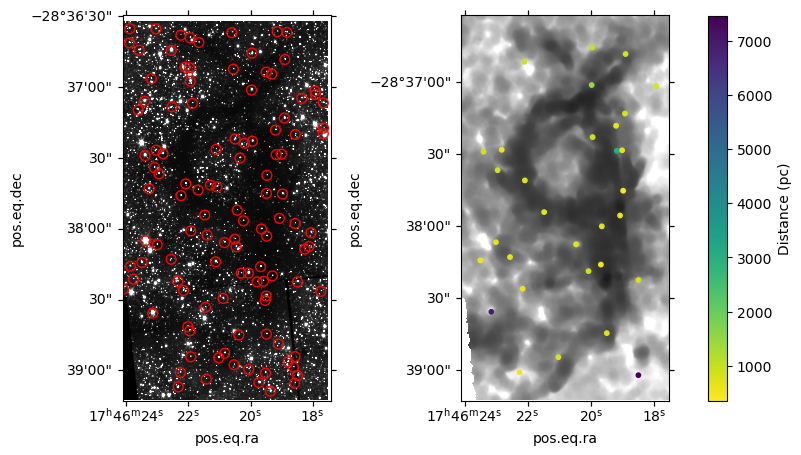

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121, projection=cutout_182.wcs)
ax.imshow(cutout_182.data, origin='lower', cmap='gray', vmin=0, vmax=50)#, norm=simple_norm(cutout_405.data, percent=99))
ax.scatter(gaia_catalog.ra, gaia_catalog.dec, s=50, transform=ax.get_transform('world'), edgecolor='red', facecolor='none')

ax2 = plt.subplot(122, projection=cutout_filt.wcs, sharex=ax, sharey=ax)
ax2.imshow(cutout_filt.data, origin='lower', cmap='gray', vmin=0, vmax=5)
im = ax2.scatter(gaia_catalog.ra, gaia_catalog.dec, s=10, transform=ax2.get_transform('world'), c=gaia['Dist'], cmap='viridis_r')#, edgecolor='black')
plt.colorbar(im, ax=(ax, ax2), label='Distance (pc)')

#plt.tight_layout()

Text(0, 0.5, 'Number of Sources')

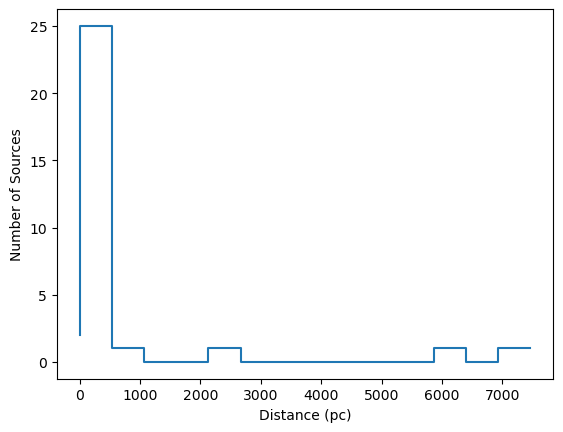

In [ ]:
h, bins = np.histogram(gaia['Dist'], bins=np.linspace(0, 8000, num=16))

plt.step(bins[:-1], h)
plt.xlabel('Distance (pc)')
plt.ylabel('Number of Sources')

In [ ]:
gaia.write(f'{basepath}/catalogs/gaia_filament.fits')